# Reddit Subreddit Classification
## Notebook 2 - Exploratory Data Analysis
---

## Import Libraries

In [218]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import utilities.graph as graph
import re

pd.options.display.max_colwidth = 200


## Import Data

In [219]:
subreddit_df = pd.read_csv("./data/final.csv")

## Exploratory Data Analysis

Two different general approaches of exploration were taken for this analysis. 
1. The first approach was to vectorize the text before any manual exploration, fit a logistic regression model with lasso regularization to it, and check the coefficients calculated to see which of the vectorized features (words) were deemed the most important in distinguishing between the two classes.
2. The second approach was to explore the vectorized text itself to look for words that were similarly common between the two classes to see if additional stop words could be added.

To aid exploration of vectorized text in context with the other features in our dataset, the following function was used to vectorize a named text column and to add it to the original dataframe.

In [220]:
# Function to take a dataframe, vectorize the text in the named text column 
# using sklearn's CountVectorizer or TfidfVectorizer
# and return the dataframe with the text vectorized columns added

def add_vectorized_to_df(df, text_column, vec_params, drop_text_col = True):
    # Create copy of input dataframe
    df_copy = df.copy()
    
    # If type in params is "count", use CountVectorizer
    if vec_params["vec_type"]=="count":
        vec = CountVectorizer(
            stop_words = vec_params.get("stop_words"),
            max_features = vec_params.get("max_features"),
            ngram_range = vec_params.get("ngram_range"),
            min_df = vec_params.get("min_df"),
        )
    # If type is "tfid" use TfidVectorizer
    elif vec_params["vec_type"]=="tfid":
        vec = TfidfVectorizer(
            stop_words = vec_params.get("stop_words"),
            max_features = vec_params.get("max_features"),
            ngram_range = vec_params.get("ngram_range"),
            min_df = vec_params.get("min_df"),
        )
    
    # Vectorize text column and create its own dataframe
    df_vec_sparse = vec.fit_transform(df_copy[text_column])
    df_vec = pd.DataFrame(df_vec_sparse.todense(), columns=vec.get_feature_names())
    
    # Reset indicies for dataframe of text-vectorized data and input dataframe
    df_vec.reset_index(inplace=True, drop=True)
    df_copy.reset_index(inplace=True, drop=True)
    
    # If drop_text_col is True, drop the original text column
    if drop_text_col:
        df_copy.drop(columns=[text_column], inplace=True)
    
    return pd.concat([df_copy, df_vec], axis=1)

### Logistic Regression Coefficient Analysis

In [221]:
# Create dataframe with CountVectorized text columns

# Params for text vectorizer
logreg_vec_params = {
    "vec_type": "tfid",
    "stop_words": None,
    "max_features": None,
    "ngram_range": (1,1),
    "min_df": 2
}

# Create dataframe
logreg_eda_df = add_vectorized_to_df(subreddit_df, "alltext", logreg_vec_params)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [222]:
# Create X and y variables for logistic regression model
X = logreg_eda_df.drop(columns=["||__target__||"])
y = logreg_eda_df['||__target__||']

# Create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [223]:
# Instantiate logistic regression model for lasso with an alpha of 10 (C=0.1)
log = LogisticRegression(solver='liblinear', penalty="l1", C=1)

# Fit model
log.fit(X_train, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [224]:
# Evaluate model

log.score(X_train, y_train), log.score(X_test, y_test)

(0.8286794648051192, 0.8027923211169284)

In [225]:
# Create dataframe with features and coefficient calculated by logistic regression model
coefficient_df = pd.DataFrame(list(zip(log.feature_names_in_, log.coef_[0])), columns=["features", "coefficient"])

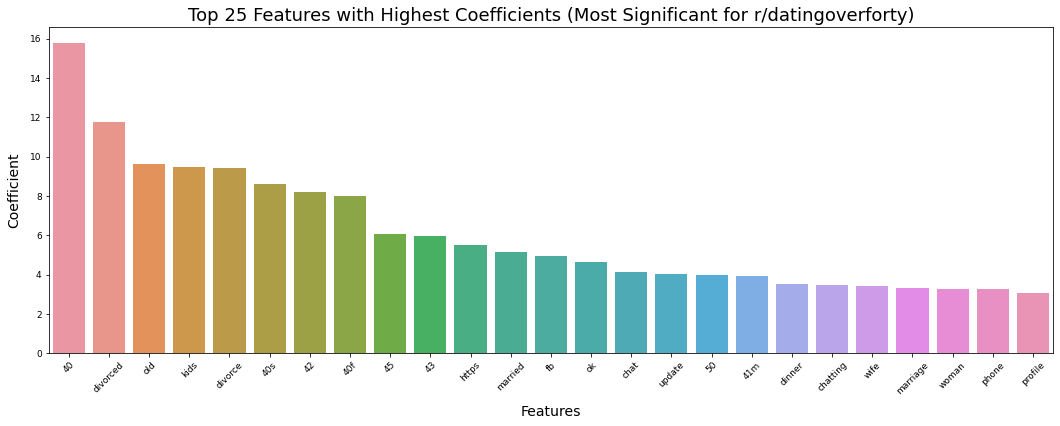

In [226]:
# Dataframe with 25 features with highest coefficients (corresponding with r/datingoverforty)
top_25 = coefficient_df.sort_values("coefficient", ascending=False).head(25)

# Plot bar chart
graph.my_barplot(top_25, "features", "coefficient", "Top 25 Features with Highest Coefficients (Most Significant for r/datingoverforty)", size=18)

This chart shows the words the logistic regression model calculated with the highest coefficients. We can interpret these coefficients to mean that if these words are present in a subreddit post, it would have more of an impact than other words with lower coefficients on the chances that post is classified as class 1 (r/datingoverforty).

Many of these words can be categorized under several common topics:
1. Numbers of 40 and above (most likely the recitation of a poster's age)
2. Divorce
3. Children
4. Marriage


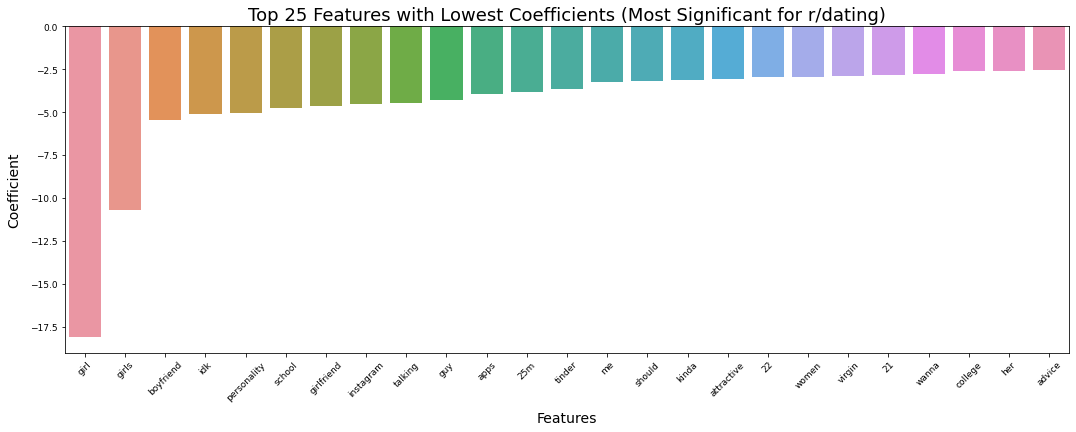

In [228]:
# Dataframe with 25 features with lowest coefficients (corresponding with subreddit class 0)
bottom_25 = coefficient_df.sort_values("coefficient", ascending=True).head(25)
bottom_25['coefficient'] = bottom_25['coefficient']

# Plot bar chart
graph.my_barplot(bottom_25, "features", "coefficient", "Top 25 Features with Lowest Coefficients (Most Significant for r/dating)", size=18)

The words with the lowest coefficients would have most significant impact in the logistic regression model classifying the post as class 0, r/dating.

The common themes among these words appear to be:
1. The use of the words "girl", "girlfriend" and "boyfriend"
2. Numbers in the 20s (again most likely the recitation of a poster's age)
3. School/College

### Most Common Words Analysis

In [229]:
# Create dataframe with CountVectorized text columns

# Params for text vectorizer
common_words_vec_params = {
    "vec_type": "count",
    "stop_words": "english",
    "max_features": None,
    "ngram_range": (1,1),
    "min_df": 2
}

# Create dataframe
common_words_eda_df = add_vectorized_to_df(subreddit_df, "alltext", common_words_vec_params)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [230]:
# Drop sentiment analysis data
common_words_eda_df.drop(columns=["||__neg__||", "||__neu__||", "||__pos__||", "||__compound__||"], inplace=True)

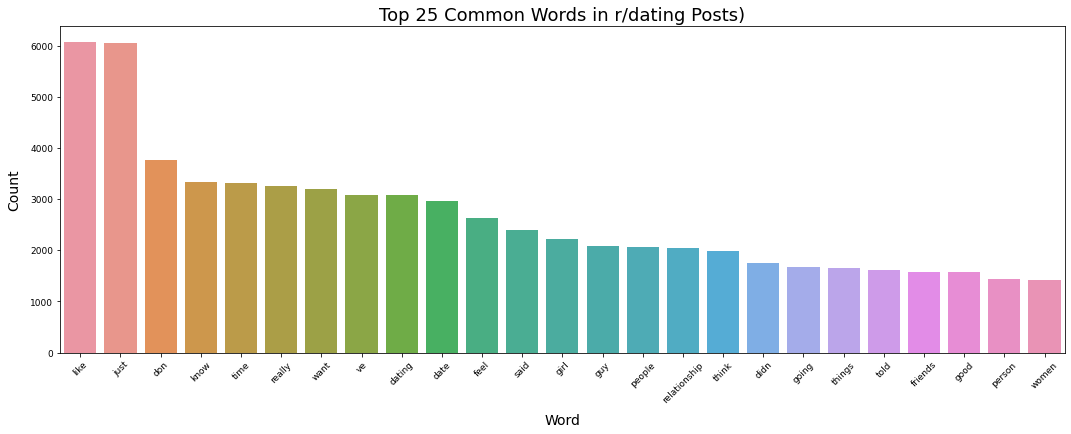

In [231]:
# Most common words in r/dating
top_25_words = common_words_eda_df[common_words_eda_df["||__target__||"] == 0].drop(columns=["||__target__||"]).sum().sort_values(ascending=False).head(25)

top_25_words_df = pd.DataFrame({"word": top_25_words.index, "count": top_25_words})

# Plot bar chart
graph.my_barplot(top_25_words_df, "word", "count", "Top 25 Common Words in r/dating Posts)", size=18)

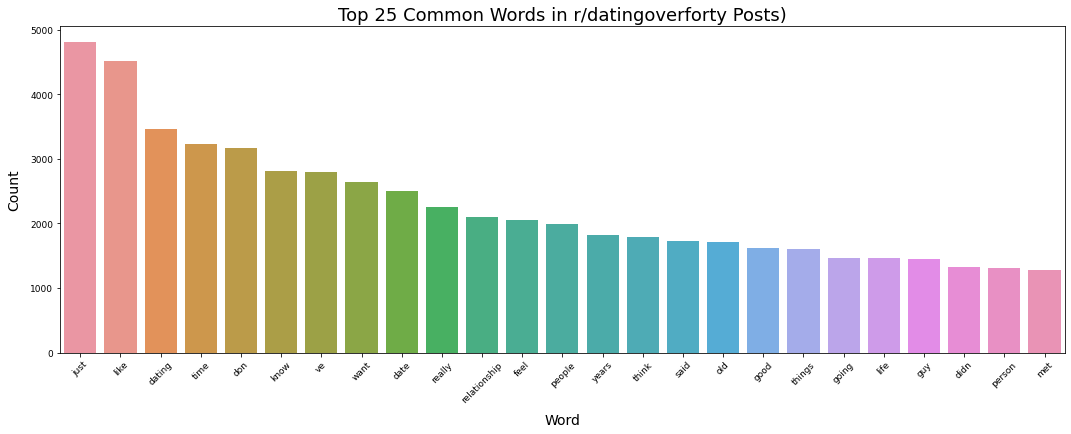

In [232]:
# Most common words in r/dating
top_25_words_forty = common_words_eda_df[common_words_eda_df["||__target__||"] == 1].drop(columns=["||__target__||"]).sum().sort_values(ascending=False).head(25)

top_25_words_forty_df = pd.DataFrame({"word": top_25_words_forty.index, "count": top_25_words_forty})

# Plot bar chart
graph.my_barplot(top_25_words_forty_df, "word", "count", "Top 25 Common Words in r/datingoverforty Posts)", size=18)

Upon analyzing these lists, I determined that the following words as canidates for additional stop words:
- just
- like
- date
- dating
- ve (presumably the latter half of the word I've)
- want
- time
- relationship
- think
- feel
- people
- don
- really
- know
- said
- didn
- things
- going
- good
- person